In [2]:
%pip install opencv-python scikit-image pandas seaborn

Note: you may need to restart the kernel to use updated packages.


In [3]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from collections import defaultdict
from sklearn.utils import shuffle
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from skimage.feature import hog

%matplotlib inline
plt.style.use("seaborn-v0_8")


In [4]:
import os

# Get the absolute path of the current notebook
notebook_dir = os.path.dirname(os.path.abspath("__file__"))  # fallback for scripts
try:
    import ipynbname
    notebook_dir = os.path.dirname(ipynbname.path())
except:
    pass  # continue with __file__-based guess

# Go two levels up and into "data" folder
base_path = os.path.abspath(os.path.join(notebook_dir, "..", "..", "data"))

# Sanity checks
print("Resolved dataset path:", base_path)
if not os.path.isdir(base_path):
    raise FileNotFoundError(f"Could not find data directory at: {base_path}")
if not os.path.isdir(os.path.join(base_path, "train")) or not os.path.isdir(os.path.join(base_path, "test")):
    raise FileNotFoundError(f"'train' and/or 'test' folder missing inside: {base_path}")


Resolved dataset path: c:\computervision\cv25-group05\data


In [5]:
def count_images_per_emotion(folder_path):
    counts = defaultdict(int)
    for emotion in os.listdir(folder_path):
        emotion_path = os.path.join(folder_path, emotion)
        if os.path.isdir(emotion_path):
            counts[emotion] = len(os.listdir(emotion_path))
    return dict(counts)

train_counts = count_images_per_emotion(os.path.join(base_path, "train"))
test_counts = count_images_per_emotion(os.path.join(base_path, "test"))

print("Image count in training set:")
print(train_counts)

print("\nImage count in test set:")
print(test_counts)


Image count in training set:
{'angry': 3995, 'disgusted': 436, 'fearful': 4097, 'happy': 7215, 'neutral': 4965, 'sad': 4830, 'surprised': 3171}

Image count in test set:
{'angry': 958, 'disgusted': 111, 'fearful': 1024, 'happy': 1774, 'neutral': 1233, 'sad': 1247, 'surprised': 831}


In [6]:
# Get emotion labels from the folder names
emotion_labels = sorted(os.listdir(os.path.join(base_path, "train")))
label_mapping = {emotion: idx for idx, emotion in enumerate(emotion_labels)}

def load_images_and_labels(base_folder):
    images = []
    labels = []
    for emotion in emotion_labels:
        folder = os.path.join(base_folder, emotion)
        for filename in os.listdir(folder):
            path = os.path.join(folder, filename)
            img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
            if img is None:
                print(f"⚠️ Could not read image: {path}")
                continue
            try:
                img = cv2.resize(img, (48, 48))
                images.append(img)
                labels.append(label_mapping[emotion])
            except Exception as e:
                print(f"⚠️ Failed to process {path}: {e}")
    return np.array(images), np.array(labels)

X_train_images, y_train = load_images_and_labels(os.path.join(base_path, "train"))
X_test_images, y_test = load_images_and_labels(os.path.join(base_path, "test"))


In [7]:
def extract_canny_features(image_array):
    features = []
    for img in image_array:
        # Apply Canny edge detection
        edges = cv2.Canny(img, threshold1=100, threshold2=200)
        features.append(edges.flatten())  # Flatten to 1D
    return np.array(features)

X_train_canny = extract_canny_features(X_train_images)
X_test_canny = extract_canny_features(X_test_images)

# Check shapes
print(f"Canny feature shape: {X_train_canny.shape}")
print(f"Number of labels: {y_train.shape}")



Canny feature shape: (28709, 2304)
Number of labels: (28709,)


In [8]:
subset_size = min(10000, len(X_train_canny))

if subset_size == 0:
    raise ValueError("No training data found. Make sure Canny features were extracted correctly.")

X_train_canny, y_train = shuffle(X_train_canny, y_train, random_state=42)
X_train_subset = X_train_canny[:subset_size]
y_train_subset = y_train[:subset_size]

# Train SVM on Canny features
model = SVC(kernel='linear', probability=True)
model.fit(X_train_subset, y_train_subset)

SVC(kernel='linear', probability=True)

Accuracy (Canny): 0.2555029256060184

Classification Report (Canny):

              precision    recall  f1-score   support

       angry       0.19      0.27      0.22       958
   disgusted       0.15      0.15      0.15       111
     fearful       0.18      0.23      0.20      1024
       happy       0.36      0.34      0.35      1774
     neutral       0.24      0.21      0.22      1233
         sad       0.22      0.16      0.19      1247
   surprised       0.36      0.31      0.33       831

    accuracy                           0.26      7178
   macro avg       0.24      0.24      0.24      7178
weighted avg       0.26      0.26      0.26      7178



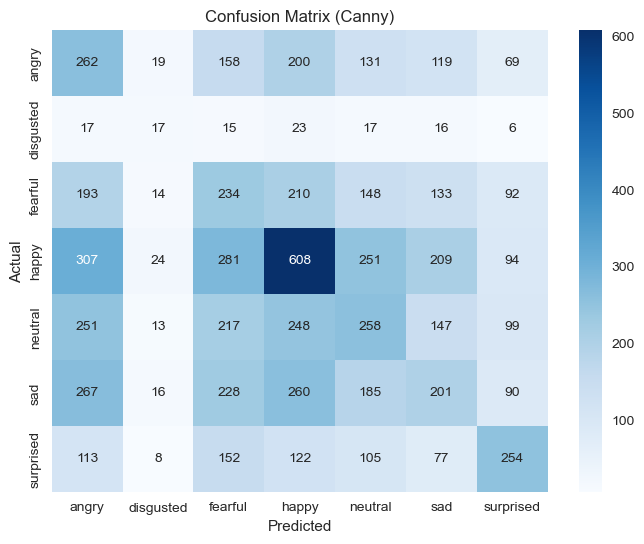

In [9]:
y_pred = model.predict(X_test_canny)

# Evaluation
print("Accuracy (Canny):", accuracy_score(y_test, y_pred))
print("\nClassification Report (Canny):\n")
print(classification_report(y_test, y_pred, target_names=emotion_labels))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, xticklabels=emotion_labels, yticklabels=emotion_labels, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (Canny)")
plt.show()